In [1]:
library(data.table)
library(tidyverse)
library(cowplot)
library(ggplot2)
#library(waffle)
library(biomaRt)
library(readxl)

setDTthreads(10)
setwd("/gpfs/commons/groups/lappalainen_lab/sghatan/stingseq_eqtl_overlap/Post_coloc_analysis/")

# Get Ensembl v99 protein coding genes
ensembl <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")
gene_list <- getBM(attributes = c("ensembl_gene_id", "external_gene_name", "hgnc_symbol", "chromosome_name", "transcription_start_site"), 
                              filters = "biotype", 
                              values = "protein_coding", 
                              mart = ensembl)
protein_coding_genes <- gene_list$ensembl_gene_id

# Load gencode data
annot_file = "/gpfs/commons/groups/lappalainen_lab/woliveros/231005_OneK1K/data/Gencode/gencode.v33lift37.GRCh38.genes.gtf"
# Annotation file
annot <- read.table(annot_file, header = F, sep = "\t", stringsAsFactors = F)
## Keep only genes from chr1-22
annot <- annot[annot$V1 %in% c(paste0("chr", 1:22)), ]
annot <- annot[annot$V3 %in% "gene", ]
annot$ensembl_id <- sapply(annot$V9, function(x) {
  unlist(strsplit(sub("gene_id ", "", unlist(strsplit(x, ";"))[1]), "[.]"))[1]
})
annot$gene_name <- sapply(annot$V9, function(x) {
  unlist(strsplit(sub(".*gene_name ", "", unlist(strsplit(x, ";"))[4]), "[.]"))[1]
})
## Add start (TSS -1) and end (TSS)
## Note: if strand == +, then (start - 1, start)
## Note: if strand == -, then (end -1, end)
annot$start <- ifelse(annot$V7 %in% "+", annot$V4 - 1, annot$V5 - 1)
annot$end <- ifelse(annot$V7 %in% "+", annot$V4, annot$V5)
annot$chr_number <- as.numeric(sub("chr", "", annot$V1))
annot.GRC37 <- annot[order(annot$chr_number, annot$start),c("chr_number","start","ensembl_id", "gene_name")]
annot.GRC37 = annot.GRC37[annot.GRC37$ensembl_id %in% protein_coding_genes,]

# Load Mendelian genes
download.file("https://ars.els-cdn.com/content/image/1-s2.0-S0092867420309995-mmc7.xlsx", "mendelian_genes.xlsx")
curated_genes = read_xlsx("mendelian_genes.xlsx") %>%
  rename(gene_name = Gene_Symbol_HGNC) %>%
  left_join(annot.GRC37, "gene_name") %>% drop_na() %>%
  distinct(ensembl_id, .keep_all = T) %>%
  dplyr::select(gene_name,chr_number,start,ensembl_id)

# UKBB WES blood cell trait genes
ukbb_genes = fread("data/genebass/blood_trait_burden_test_genes.csv", sep = ",")
ukbb_genes = ukbb_genes[grep("pLoF", ukbb_genes$annotation),] %>%
  distinct(gene_id, .keep_all = T) %>%
  rename(ensembl_id = gene_id) %>%
  left_join(annot.GRC37, "ensembl_id") %>% drop_na() %>%
  dplyr::select(gene_name,chr_number,start,ensembl_id)

#ok = fread("rare_genes_list.txt")
gw.rare.genes = rbind(ukbb_genes,curated_genes)

cres_w_grnas_egene = fread("cres_with_grna_eqtls.txt")

cres_w_grnas = fread("cres_with_grnas.txt") 

sig.grna.targets = cres_w_grnas %>%
  distinct(grna_target, .keep_all=T) %>% 
  filter(significant == 1 | grna_target %in% cres_w_grnas_egene$grna_target)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖

In [2]:
#-----------------------------#
# Load CRISPR eQTL and GRNA target data
#-----------------------------#
cres_w_grnas_egene <- fread("cres_with_grna_eqtls.txt")
cres_w_grnas <- fread("cres_with_grnas.txt")

# Significant gRNA targets and genes
cgene.targets <- cres_w_grnas %>%
  filter(significant == 1) %>%
  dplyr::select(grna_target, cgene = ensembl_id)

egene.targets = cres_w_grnas_egene %>%
  distinct(target_gene, .keep_all = T) %>%
  dplyr::select(grna_target, egene = ensembl_id)
  
all.grna.targets = cres_w_grnas %>%
  distinct(grna_target, .keep_all = TRUE)

#-----------------------------#
# Define a function to find cis genes
#-----------------------------#
find.cis <- function(chr, pos, grna_target) {
  cre.rare.genes <- gw.rare.genes %>%
    filter(chr_number == chr & start >= (pos - 1e6) & start <= (pos + 1e6)) %>%
    mutate(grna_target = grna_target)
  return(cre.rare.genes)
}

# Apply the function across all significant targets
results <- lapply(1:nrow(all.grna.targets), function(x) {
  find.cis(chr = all.grna.targets$chr[x], 
           pos = all.grna.targets$grna_pos[x],
           grna_target = all.grna.targets$grna_target[x])
})

# Combine results into one dataframe
# Consolidate duplicate genes and combine grna targets
gold_cis_genes <- bind_rows(results) %>%
  left_join(cgene.targets, by = "grna_target") %>%
  left_join(egene.targets, by = "grna_target") %>%
  rename(gold_gene = ensembl_id) %>%
  group_by(gene_name, chr_number, start, gold_gene) %>%
  summarise(
    grna_target = paste(unique(grna_target), collapse = ","),
    cgene = paste(unique(cgene), collapse = ","),
    egene = paste(unique(egene), collapse = ","),
    .groups = "drop"
  ) %>%
  # Calculate cgene_multiple excluding NA, empty strings, and genes equal to gold_gene
  mutate(
    cgene_multiple = mapply(function(cgenes, gold) {
      sum(str_trim(str_split(cgenes, ",")[[1]]) != "NA" &
            str_trim(str_split(cgenes, ",")[[1]]) != "" &
            str_trim(str_split(cgenes, ",")[[1]]) != gold)
    }, cgene, gold_gene),
    
    # Calculate egene_multiple with similar conditions
    egene_multiple = mapply(function(egenes, gold) {
      sum(str_trim(str_split(egenes, ",")[[1]]) != "NA" &
            str_trim(str_split(egenes, ",")[[1]]) != "" &
            str_trim(str_split(egenes, ",")[[1]]) != gold)
    }, egene, gold_gene)
  )

Warning message in left_join(., cgene.targets, by = "grna_target"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 30 of `x` matches multiple rows in `y`.
ℹ Row 3 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”
Warning message in left_join(., egene.targets, by = "grna_target"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 7 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”


In [3]:
# load cgenes and egenes
# Load predicted gene sets
gold_genes <- gold_cis_genes %>%
  mutate(grna = strsplit(grna_target, ",")) %>%
  unnest(grna)

cres_w_grnas <- fread("cres_with_grnas.txt") %>%
  filter(grna_target %in% gold_genes$grna)
cgenes <- unique(cres_w_grnas$ensembl_id[cres_w_grnas$significant == TRUE])
cgenes = cgenes[cgenes %in% protein_coding_genes]

cres_w_grnas_egene <- fread("cres_with_grna_eqtls.txt") %>%
  filter(grna_target %in% gold_genes$grna)
egenes <- unique(cres_w_grnas_egene$ensembl_id)
egenes = egenes[egenes %in% protein_coding_genes]

calculate_enrichment = function(mendel_genes){
  # Set the number of iterations
  n_iterations <- 10000
  
  # Initialize a vector to store the overlaps
  cgene_overlap_counts <- numeric(n_iterations)
  egene_overlap_counts <- numeric(n_iterations)
  
  # Calculate the overlap in each iteration
  set.seed(123) # for reproducibility
  for (i in 1:n_iterations) {
    # Randomly sample a set of genes with the same size as your GWAS list
    crandom_genes <- sample(protein_coding_genes, size = length(cgenes), replace = FALSE)
    erandom_genes = sample(protein_coding_genes, size = length(egenes), replace = FALSE)
    # Calculate the number of overlapping genes
    cgene_overlap_counts[i] <- sum(crandom_genes %in% mendel_genes)
    egene_overlap_counts[i] <- sum(erandom_genes %in% mendel_genes)
  }
  
  # Take the median of the random gene overlaps
  cgene_random_counts = median(cgene_overlap_counts)
  egene_random_counts = median(egene_overlap_counts)
  
  # Observed overlap
  cgene_observed_overlap <- sum(cgenes %in% mendel_genes)
  egene_observed_overlap <- sum(egenes %in% mendel_genes)
  
  a = cgene_observed_overlap # cgene in mendel set
  b = length(cgenes) - cgene_observed_overlap # cgenes not in mendel set
  c = cgene_random_counts
  d = length(crandom_genes) - cgene_random_counts
  
  cgene_table = matrix(c(a,b,c,d), nrow = 2)
  print(cgene_table)
  
  print(fisher.test(cgene_table, alternative = "greater"))
  
  a1 = egene_observed_overlap
  b1 = length(egenes) - egene_observed_overlap
  c1 = egene_random_counts
  d1 = length(erandom_genes) - egene_random_counts
  
  egene_table = matrix(c(a1,b1,c1,d1), nrow = 2)
  print(egene_table)
  
  print(fisher.test(egene_table, alternative = 'greater'))
  
  compare_table = matrix(c(a,b,a1,b1), nrow = 2)
  print(compare_table)
  
  print(fisher.test(compare_table))
  
  print(cgenes[cgenes %in% mendel_genes])
  print(egenes[egenes %in% mendel_genes])
}
calculate_enrichment(gold_cis_genes$gold_gene)
length(gold_cis_genes$gold_gene)

     [,1] [,2]
[1,]   23    2
[2,]   84  105

	Fisher's Exact Test for Count Data

data:  cgene_table
p-value = 3.176e-06
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 3.964086      Inf
sample estimates:
odds ratio 
  14.23491 

     [,1] [,2]
[1,]   53   11
[2,]  418  460

	Fisher's Exact Test for Count Data

data:  egene_table
p-value = 1.867e-08
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 2.952736      Inf
sample estimates:
odds ratio 
  5.293361 

     [,1] [,2]
[1,]   23   53
[2,]   84  418

	Fisher's Exact Test for Count Data

data:  compare_table
p-value = 0.006874
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.193105 3.809851
sample estimates:
odds ratio 
  2.156087 

 [1] "ENSG00000183508" "ENSG00000072274" "ENSG00000179348" "ENSG00000185811"
 [5] "ENSG00000106327" "ENSG00000029534" "ENSG00000165702" "ENSG00000156515"
 [9] "ENSG00000171988" 

[1] 421

In [4]:
data <- data.frame(
  Gene_type = factor(c("cGene","eGene"), levels = c("cGene","eGene")),
  Proportion = c(23/(23+84),53/(53+418)))

svg("plots/figure_plots/burden_gene_barplot.svg", width = 4, height = 6)

burden_gene_barplot = ggplot(data, aes(x = Gene_type, y = Proportion, fill = Gene_type)) +
  geom_bar(stat = "identity", color = "black", width = 0.5, position = position_dodge(width = 0.7)) +
  theme_minimal() +
  labs(title = "", x = "", y = "Proportion of genes") +
  annotate("text", x = 1.5, y = 0.2, label = paste0("P = ", "6.8e-03"), size = 7, hjust = 0.5) +
  theme_cowplot() +
  theme(
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 16, margin = margin(l = 20)),
    axis.text.x = element_text(size = 16),
    axis.text.y = element_text(size = 16)
  )
burden_gene_barplot
#dev.off()

In [5]:
# Load sting-seq power
stingseq.p1 = fread("power_results/morris_large_power_per_pair.csv") %>%
  filter(effect_size == 0.5)
stingseq.p2 = fread("power_results/morris_small_power_per_pair.csv") %>%
  filter(effect_size == 0.5)
stingseq.p = rbind(stingseq.p1,stingseq.p2) 

gasperini.p = fread("power_results/gasperini_power_per_pair.csv") %>%
  filter(effect_size == 0.5) %>%
  mutate(cre_gene = paste0(cre_pert,"_",gene))

# Load GRC 38 genes positions
annot_file = "data/gencode.v47.annotation.gtf.gz"
annot <- read.table(annot_file, header = F, sep = "\t", stringsAsFactors = F)
## Keep only genes from chr1-22
annot <- annot[annot$V1 %in% c(paste0("chr", 1:22)), ]
annot <- annot[annot$V3 %in% "gene", ]
annot$ensembl_id <- sapply(annot$V9, function(x) {
  unlist(strsplit(sub("gene_id ", "", unlist(strsplit(x, ";"))[1]), "[.]"))[1]
})
annot$gene_name <- sapply(annot$V9, function(x) {
  unlist(strsplit(sub(".*gene_name ", "", unlist(strsplit(x, ";"))[3]), "[.]"))[1]
})
## Add start (TSS -1) and end (TSS)
## Note: if strand == +, then (start - 1, start)
## Note: if strand == -, then (end -1, end)
annot$start <- ifelse(annot$V7 %in% "+", annot$V4 - 1, annot$V5 - 1)
annot$end <- ifelse(annot$V7 %in% "+", annot$V4, annot$V5)
annot$chr_number <- as.numeric(sub("chr", "", annot$V1))
annot.GRC38 <- annot[order(annot$chr_number, annot$start),c("chr_number","start","ensembl_id", "gene_name")]

encode = fread("CRISPR_data/NoGasperini_crispri_data.tsv") %>%
  mutate(target_site = paste0(chrom_GRC37,":",chromStart_GRC37,"-",chromEnd_GRC37)) %>%
  rename(gene_name = measuredGeneSymbol) %>%
  left_join(annot.GRC38[,c("ensembl_id","gene_name")], by = "gene_name") %>%
  dplyr::select(gene = ensembl_id, fraction_sig = PowerAtEffectSize50)

crispri.power = rbind(encode, gasperini.p, stingseq.p, fill=T) %>% 
    arrange(desc(fraction_sig)) %>% 
    distinct(gene, .keep_all = T) %>%
    filter(gene %in% results2$ensembl_id & !gene %in% cgenes & fraction_sig < 0.8)

ERROR: Error in fread("power_results/morris_large_power_per_pair.csv"): File 'power_results/morris_large_power_per_pair.csv' does not exist or is non-readable. getwd()=='/gpfs/commons/groups/lappalainen_lab/sghatan/stingseq_eqtl_overlap/Post_coloc_analysis'


Loading required package: sysfonts

Loading required package: showtextdb



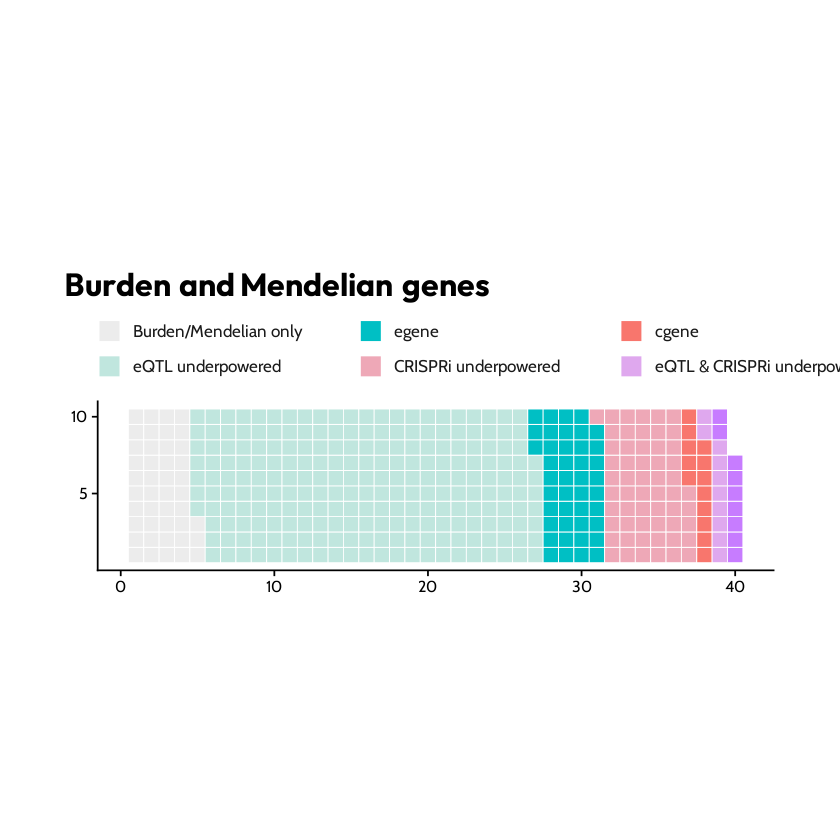

In [6]:
# Create data
library(ggpattern)
library(showtext)
library(ggtext)

both = sum(cgenes %in% results2$ensembl_id & cgenes %in% egenes)
both.underpow = 10

# Load eQTL power
eqtl.power = fread("power_results/GTEx.power.results.txt") %>%
  filter(genes %in% results2$ensembl_id & !genes %in% egenes & eQTL.power < 0.8) %>%
  distinct(genes, .keep_all=T)

gold.genes = length(results2$ensembl_id) - c(nrow(eqtl.power)+22-both+51-both+both)

group <- c("Burden/Mendelian only", "eQTL underpowered","egene","CRISPRi underpowered","cgene", "eQTL & CRISPRi underpowered" ,"egene & cgene")
value <- c(gold.genes, nrow(eqtl.power)-both.underpow, 51-both, nrow(crispri.power)-both.underpow, 22-both, both.underpow, both)
gene_data <- data.frame(group,value)

# Custom colors for the groups
custom_colors <- c(
      "Burden/Mendelian only" = "#ECECEC",
      "eQTL underpowered" = "#C0E6DE",
      "CRISPRi underpowered" = "#EEA8B7",
      "eQTL & CRISPRi underpowered" = "#DFA8EE",
      "cgene" = "#F8766D",
      "egene" = "#00BFC4",
      "egene & cgene" = "#C77CFF")

font_add_google("Outfit", "title_font")
font_add_google("Cabin", "body_font")
showtext_auto()

title_font <- "title_font"
body_font <- "body_font"
title_text = "Overlap with gold standard genes"

gene_data$group <- factor(gene_data$group, levels = c("Burden/Mendelian only", "eQTL underpowered", "egene", "CRISPRi underpowered", "cgene","eQTL & CRISPRi underpowered", "egene & cgene"))

# Create a waffle plot with custom colors and patterns
# Waffle plot
ggplot(gene_data, aes(fill = group, values = value)) +
  geom_waffle(color = "white", size = 0.25,flip=F, n_rows = 10) +
  scale_fill_manual(values = custom_colors) +
  coord_equal()+
  theme_cowplot() +
  scale_y_continuous(breaks = c(5, 10)) +
  labs(title = "Burden and Mendelian genes", fill = "Group") +
  theme(
    axis.title = element_blank(),
    axis.text.x = element_text(family = body_font, size=12),
    axis.text.y = element_text(family = body_font, size=12),
  # Legend
  legend.position = "top",
  legend.title = element_blank(),
  legend.spacing = unit(0.2, 'cm'),
  legend.key.height= unit(0.5, 'cm'),
  legend.key.width= unit(0.5, 'cm'),
  legend.text = element_text(family = body_font,
                             size=13,
                             face = 'plain',
                             color = "grey10"),
  
  # TITLE
  plot.title.position = "plot",
  plot.title = element_textbox(margin = margin(20, 0, 10, 0),
                               size = 24,
                               family = title_font,
                               face = "bold",
                               width = unit(55, "lines")),
  
  # SUB-TITLE
  plot.subtitle = element_text(margin = margin(10, 0, 20, 0),
                            size = 16,
                            family = body_font,
                            color = "grey15"),
  # Caption
  plot.caption = element_text(family=body_font,
                              face="plain",
                              size=14, 
                              color="grey40",
                              hjust=.5,
                              margin=margin(20,0,0,0)),
  
  plot.background = element_rect(color="white", fill="white"),
  plot.margin = margin(20, 40, 20, 40)
)

#showtext_opts(dpi = 320)
#ggsave(
#  "plots/waffle_plot.png",
#  dpi=320, width = 12, height = 9
#)

In [10]:
install.packages("showtext")

Installing package into ‘/gpfs/commons/home/sghatan/R/x86_64-conda-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

also installing the dependencies ‘sysfonts’, ‘showtextdb’


Warning message in install.packages("showtext"):
“installation of package ‘sysfonts’ had non-zero exit status”
Warning message in install.packages("showtext"):
“installation of package ‘showtextdb’ had non-zero exit status”
Warning message in install.packages("showtext"):
“installation of package ‘showtext’ had non-zero exit status”


In [9]:
# Create data
library(showtext)
library(ggtext)

both = sum(cgenes %in% results2$ensembl_id & cgenes %in% egenes)
both.underpow = 10

# Load eQTL power
eqtl.power = fread("power_results/GTEx.power.results.txt") %>%
  filter(genes %in% results2$ensembl_id & !genes %in% egenes & eQTL.power < 0.8) %>%
  distinct(genes, .keep_all=T)

gold.genes = length(results2$ensembl_id) - c(nrow(eqtl.power)+22-both+51-both+both)

group <- c("eGene","cGene", "eGene & cGene")
value <- c(53-9, 23-9, 9)
gene_data <- data.frame(group,value)

# Custom colors for the groups
custom_colors <- c(
      "eGene" = "#d35e60",
      "cGene" = "#76c0c1",
      "eGene & cGene" = "#8e6c8a")

font_add_google("Outfit", "title_font")
font_add_google("Cabin", "body_font")
showtext_auto()

title_font <- "title_font"
body_font <- "body_font"
title_text = "Overlap with gold standard genes"

gene_data$group <- factor(gene_data$group, levels =  c("eGene","cGene", "eGene & cGene"))

# Create a waffle plot with custom colors and patterns
# Waffle plot
ggplot(gene_data, aes(fill = group, values = value)) +
  geom_waffle(color = "white", size = 0.25,flip=F, n_rows = 10) +
  scale_fill_manual(values = custom_colors) +
  coord_equal()+
  theme_cowplot() +
  scale_y_continuous(breaks = c(5, 10)) +
  labs(title = "Burden and Mendelian genes", fill = "Group") +
  theme(
    axis.title = element_blank(),
    axis.text.x = element_text(family = body_font, size=12),
    axis.text.y = element_text(family = body_font, size=12),
  # Legend
  legend.position = "top",
  legend.title = element_blank(),
  legend.spacing = unit(0.2, 'cm'),
  legend.key.height= unit(0.5, 'cm'),
  legend.key.width= unit(0.5, 'cm'),
  legend.text = element_text(family = body_font,
                             size=13,
                             face = 'plain',
                             color = "grey10"),
  
  # TITLE
  plot.title.position = "plot",
  plot.title = element_textbox(margin = margin(20, 0, 10, 0),
                               size = 24,
                               family = title_font,
                               face = "bold",
                               width = unit(55, "lines")),
  
  # SUB-TITLE
  plot.subtitle = element_text(margin = margin(10, 0, 20, 0),
                            size = 16,
                            family = body_font,
                            color = "grey15"),
  # Caption
  plot.caption = element_text(family=body_font,
                              face="plain",
                              size=14, 
                              color="grey40",
                              hjust=.5,
                              margin=margin(20,0,0,0)),
  
  plot.background = element_rect(color="white", fill="white"),
  plot.margin = margin(20, 40, 20, 40)
)

#showtext_opts(dpi = 320)
#ggsave(
#  "plots/waffle_plot.png",
#  dpi=320, width = 12, height = 9
#)

ERROR: Error in library(showtext): there is no package called ‘showtext’


In [7]:
# Which cres have a burden gene as a target
egene_burden = cres_w_grnas_egene %>% distinct(target_gene, .keep_all=T) %>% filter(ensembl_id %in% results2$ensembl_id)

cgene_burden = cres_w_grnas %>% filter(significant ==1) %>% distinct(target_gene, .keep_all=T) %>% filter(ensembl_id %in% results2$ensembl_id)


# number of associated genes per CRE and burden gene
cgenes_per_cre = cres_w_grnas %>% filter(significant ==1) %>% distinct(target_gene, .keep_all=T) %>% group_by(grna_target) %>% 
    mutate(n = n()) %>%
    ungroup() %>%
    filter(ensembl_id %in% results2$ensembl_id)

egenes_per_cre = cres_w_grnas_egene %>% distinct(target_gene, .keep_all=T) %>% group_by(grna_target) %>% 
    mutate(n = n()) %>%
    ungroup() %>%
    filter(ensembl_id %in% results2$ensembl_id)

sum(results2$ensembl_id %in% cgenes)
sum(results2$ensembl_id %in% egenes)

gold_two_cgenes = unique(cgenes_per_cre$ensembl_id[cgenes_per_cre$n > 1])
gold_two_egenes = unique(egenes_per_cre$ensembl_id[egenes_per_cre$n > 1])
gold_two_both = sum(gold_two_cgenes %in% gold_two_egenes)
sum(gold_two_cgenes %in% gold_two_egenes)

gold_one_cgenes = unique(cgenes_per_cre$ensembl_id[cgenes_per_cre$n < 2])
gold_one_egenes = unique(egenes_per_cre$ensembl_id[egenes_per_cre$n < 2])

sum(gold_two_cgenes %in% gold_one_egenes)
sum(gold_two_egenes %in% gold_one_cgenes)

cat("number of gold standard genes discovered by CRISPRi but also other cgenes" ,length(gold_two_cgenes)-gold_two_both,"\n" )
cat("number of gold standard genes discovered by eQTL but also other egenes" ,length(gold_two_egenes)-gold_two_both,"\n" )

[1] 22

[1] 51

[1] 4

[1] 2

[1] 6

number of gold standard genes discovered by CRISPRi but also other cgenes 7 
number of gold standard genes discovered by eQTL but also other egenes 36 


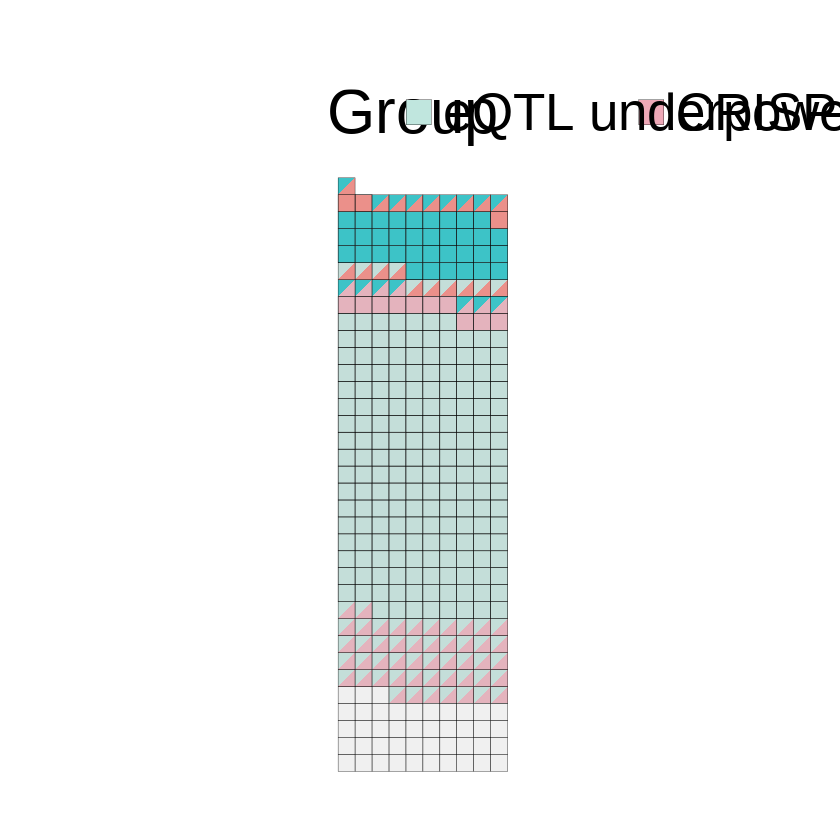

In [8]:
# Create example data
data <- expand.grid(x = 1:10, y = 1:35) %>%
  head(341) %>%  # Ensure exactly 341 tiles
  mutate(egene = results2$ensembl_id %in% egenes,
         cgene = results2$ensembl_id %in% cgenes,
         crispri_underpowered = results2$ensembl_id %in% crispri.power$gene,
         eqtl_underpowered = results2$ensembl_id %in% eqtl.power$genes)

# Define available groups with priority
group_names <- c("eQTL underpowered", "egene", "CRISPRi underpowered", "cgene")

# Assign categories based on hierarchical priority
data <- data %>%
  rowwise() %>%
  mutate(
    eqtl_underpowered = eqtl_underpowered & !egene,   # Override eQTL underpowered if egene is present
    crispri_underpowered = crispri_underpowered & !cgene,  # Override CRISPRi underpowered if cgene is present
    active_groups = list(group_names[c(eqtl_underpowered, egene, crispri_underpowered, cgene)]),
    category = paste(active_groups, collapse = " & ")  # Combine multiple groups
  ) %>%
  ungroup()

# Define colors for each category
category_colors <- c(
  "eQTL underpowered" = "#C0E6DE",
  "CRISPRi underpowered" = "#EEA8B7",
  "cgene" = "#F8766D",
  "egene" = "#00BFC4"
)

tmp_data1 = data[data$category == "",]
tmp_data2 = data[data$category == "eQTL underpowered & CRISPRi underpowered",]
tmp_data3 = data[data$category == "eQTL underpowered",]
tmp_data4 = data[data$category == "CRISPRi underpowered",]
tmp_data5 = data[data$category == "egene & CRISPRi underpowered",]
tmp_data6 = data[data$category == "eQTL underpowered & cgene",]
tmp_data7 = data[data$category == "egene",]
tmp_data8 = data[data$category == "cgene",]
tmp_data9 = data[data$category == "egene & cgene",]

new_xy = expand.grid(x2 = 1:10, y2 = 1:35) %>%
  head(341)

data_sort = cbind(rbind(tmp_data1, tmp_data2, tmp_data3, tmp_data4, tmp_data5, tmp_data6, tmp_data7, tmp_data8, tmp_data9), new_xy)
data_sort = cbind(rbind(tmp_data1, tmp_data2, tmp_data3, tmp_data4, tmp_data5, tmp_data6, tmp_data7, tmp_data8, tmp_data9), new_xy)

# Function to create triangle coordinates for diagonal split
make_triangle <- function(x, y, group) {
  if (group == "first") {
    # Bottom-left triangle
    tibble(
      x_coord = c(x - 0.5, x + 0.5, x - 0.5),
      y_coord = c(y - 0.5, y + 0.5, y + 0.5)
    )
  } else {
    # Top-right triangle
    tibble(
      x_coord = c(x + 0.5, x - 0.5, x + 0.5),
      y_coord = c(y + 0.5, y - 0.5, y - 0.5)
    )
  }
}

# Handle tiles with one or two groups
single_group_tiles <- data_sort %>%
  filter(lengths(active_groups) == 1) %>%
  mutate(fill_color = category_colors[active_groups[[1]]])

split_group_tiles <- data_sort %>%
  filter(lengths(active_groups) == 2) %>%
  rowwise() %>%
  mutate(
    first_group = active_groups[[1]],  # Get first group
    second_group = active_groups[[2]]  # Get second group
  ) %>%
  pivot_longer(cols = c(first_group, second_group), names_to = "part", values_to = "group") %>%
  mutate(fill_color = category_colors[group]) %>%
  rowwise() %>%
  mutate(coords = list(make_triangle(x2, y2, ifelse(part == "first_group", "first", "second")))) %>%
  unnest(coords)

# Convert color mapping to factors for the legend
single_group_tiles <- single_group_tiles %>%
  mutate(group_label = factor(category, levels = names(category_colors)))

split_group_tiles <- split_group_tiles %>%
  mutate(group_label = factor(group, levels = names(category_colors)))

# Plot
ggplot() +
  # Full color tiles for single-group squares
  geom_tile(data = single_group_tiles, aes(x = x2, y = y2, fill = group_label), color = "black") +
  # Diagonal split tiles
  geom_polygon(data = split_group_tiles, aes(x = x_coord, y = y_coord, group = interaction(x, y, group), fill = group_label), color = NA) +
  # Background grid
  geom_tile(data = data_sort, aes(x = x, y = y), fill = "grey80", color = "black", alpha = 0.3) +
  scale_fill_manual(values = category_colors, name = "Group") +  # Add legend
  coord_fixed() +
  theme_cowplot() +
  theme(
    legend.position = "top",
    # Remove axis text, ticks, and titles
    axis.line = element_blank(),
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    axis.title = element_blank(),
      plot.background = element_rect(color="white", fill="white"),
      plot.margin = margin(20, 40, 20, 40)
  ) +
  labs(title = "")

showtext_opts(dpi = 320)
ggsave(
  "plots/figure_plots/waffle_plot.png",
  dpi=320, width = 12, height = 9
)

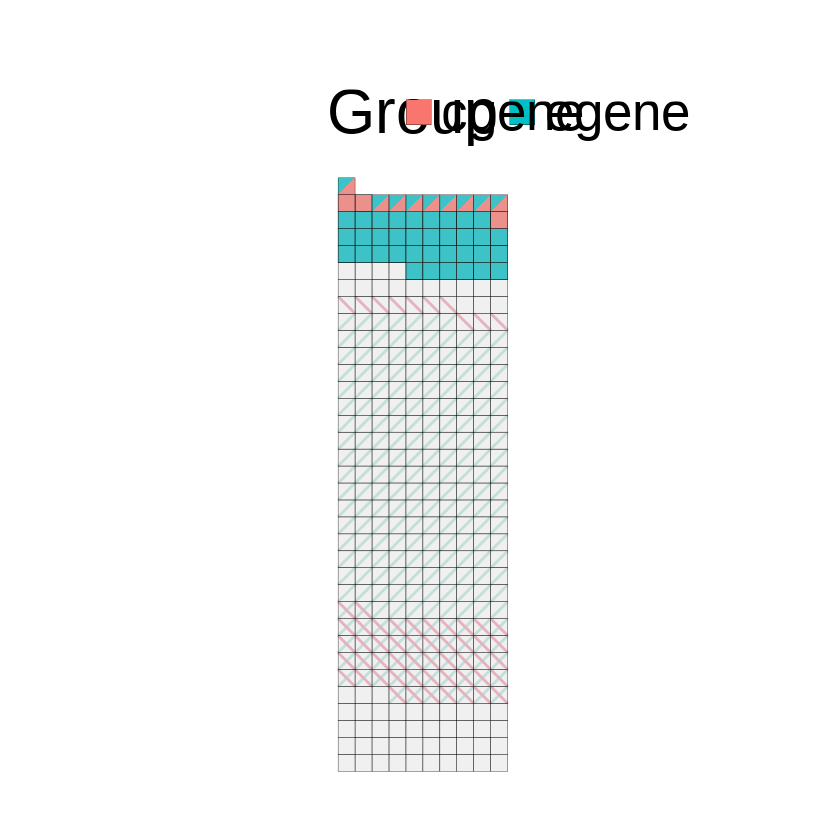

In [10]:
# Create example data
data <- expand.grid(x = 1:10, y = 1:35) %>%
  head(341) %>%  # Ensure exactly 341 tiles
  mutate(egene = results2$ensembl_id %in% egenes,
         cgene = results2$ensembl_id %in% cgenes,
         crispri_underpowered = results2$ensembl_id %in% crispri.power$gene,
         eqtl_underpowered = results2$ensembl_id %in% eqtl.power$genes)

# Define available groups with priority
group_names <- c("eQTL underpowered", "egene", "CRISPRi underpowered", "cgene")

# Assign categories based on hierarchical priority
data <- data %>%
  rowwise() %>%
  mutate(
    eqtl_underpowered = eqtl_underpowered & !egene,   # Override eQTL underpowered if egene is present
    crispri_underpowered = crispri_underpowered & !cgene,  # Override CRISPRi underpowered if cgene is present
    active_groups = list(group_names[c(eqtl_underpowered, egene, crispri_underpowered, cgene)]),
    category = paste(active_groups, collapse = " & ")  # Combine multiple groups
  ) %>%
  ungroup()

# Define colors for each category
category_colors <- c(
  "eQTL underpowered" = "#C0E6DE",
  "CRISPRi underpowered" = "#EEA8B7",
  "cgene" = "#F8766D",
  "egene" = "#00BFC4"
)

# Data sorting process
tmp_data1 = data[data$category == "",]
tmp_data2 = data[data$category == "eQTL underpowered & CRISPRi underpowered",]
tmp_data3 = data[data$category == "eQTL underpowered",]
tmp_data4 = data[data$category == "CRISPRi underpowered",]
tmp_data5 = data[data$category == "egene & CRISPRi underpowered",]
tmp_data6 = data[data$category == "eQTL underpowered & cgene",]
tmp_data7 = data[data$category == "egene",]
tmp_data8 = data[data$category == "cgene",]
tmp_data9 = data[data$category == "egene & cgene",]

new_xy = expand.grid(x2 = 1:10, y2 = 1:35) %>%
  head(341)

data_sort = cbind(rbind(tmp_data1, tmp_data2, tmp_data3, tmp_data4, tmp_data5, tmp_data6, tmp_data7, tmp_data8, tmp_data9), new_xy)

# Handle single-group tiles, excluding categories with diagonal lines
single_group_tiles <- data_sort %>%
  filter(lengths(active_groups) == 1, !category %in% c("eQTL underpowered", "CRISPRi underpowered")) %>%
  mutate(fill_color = category_colors[active_groups[[1]]])

# Extract split group tiles, excluding categories with diagonal lines
split_group_tiles <- data_sort %>%
  filter(lengths(active_groups) == 2, !category %in% c("eQTL underpowered & CRISPRi underpowered", "egene & CRISPRi underpowered","eQTL underpowered & cgene")) %>%
  rowwise() %>%
  mutate(
    first_group = active_groups[[1]],  
    second_group = active_groups[[2]]  
  ) %>%
  pivot_longer(cols = c(first_group, second_group), names_to = "part", values_to = "group") %>%
  mutate(fill_color = category_colors[group]) %>%
  rowwise() %>%
  mutate(coords = list(make_triangle(x2, y2, ifelse(part == "first_group", "first", "second")))) %>%
  unnest(coords)

# Convert color mapping to factors for the legend
single_group_tiles <- single_group_tiles %>%
  mutate(group_label = factor(category, levels = names(category_colors)))

split_group_tiles <- split_group_tiles %>%
  mutate(group_label = factor(group, levels = names(category_colors)))

# Extract only the categories that should have diagonal lines
diagonal_lines <- data_sort %>%
  filter(category %in% c("eQTL underpowered", "CRISPRi underpowered", "eQTL underpowered & CRISPRi underpowered")) %>%
  dplyr::select(x2, y2, category)

# Plot
ggplot() +
  # Full color tiles for single-group squares (excluding diagonal-line categories)
  geom_tile(data = single_group_tiles, aes(x = x2, y = y2, fill = group_label), color = "black") +
  # Diagonal split tiles for multi-group squares (excluding diagonal-line categories)
  geom_polygon(data = split_group_tiles, aes(x = x_coord, y = y_coord, group = interaction(x, y, group), fill = group_label), color = NA) +
  # Add diagonal lines for "eQTL underpowered" (light blue)
  geom_segment(data = diagonal_lines %>% filter(category == "eQTL underpowered"),
               aes(x = x2 - 0.5, y = y2 - 0.5, xend = x2 + 0.5, yend = y2 + 0.5),
               color = category_colors["eQTL underpowered"], size = 0.8) +
  # Add diagonal lines for "CRISPRi underpowered" (pink)
  geom_segment(data = diagonal_lines %>% filter(category == "CRISPRi underpowered"),
               aes(x = x2 - 0.5, y = y2 + 0.5, xend = x2 + 0.5, yend = y2 - 0.5),
               color = category_colors["CRISPRi underpowered"], size = 0.8) +
  # Add cross-diagonal lines for "eQTL underpowered & CRISPRi underpowered"
  geom_segment(data = diagonal_lines %>% filter(category == "eQTL underpowered & CRISPRi underpowered"),
               aes(x = x2 - 0.5, y = y2 - 0.5, xend = x2 + 0.5, yend = y2 + 0.5),
               color = category_colors["eQTL underpowered"], size = 0.8) +
  geom_segment(data = diagonal_lines %>% filter(category == "eQTL underpowered & CRISPRi underpowered"),
               aes(x = x2 - 0.5, y = y2 + 0.5, xend = x2 + 0.5, yend = y2 - 0.5),
               color = category_colors["CRISPRi underpowered"], size = 0.8) +
  # Background grid
  geom_tile(data = data_sort, aes(x = x, y = y), fill = "grey80", color = "black", alpha = 0.3) +
  scale_fill_manual(values = category_colors, name = "Group") +  # Add legend
  coord_fixed() +
  theme_cowplot() +
  theme(
    legend.position = "top",
    axis.line = element_blank(),
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    axis.title = element_blank(),
    plot.background = element_rect(color="white", fill="white"),
    plot.margin = margin(20, 40, 20, 40)
  ) +
  labs(title = "")

showtext_opts(dpi = 320)
ggsave(
  "plots/figure_plots/waffle_plot2.png",
  dpi=320, width = 12, height = 9
)

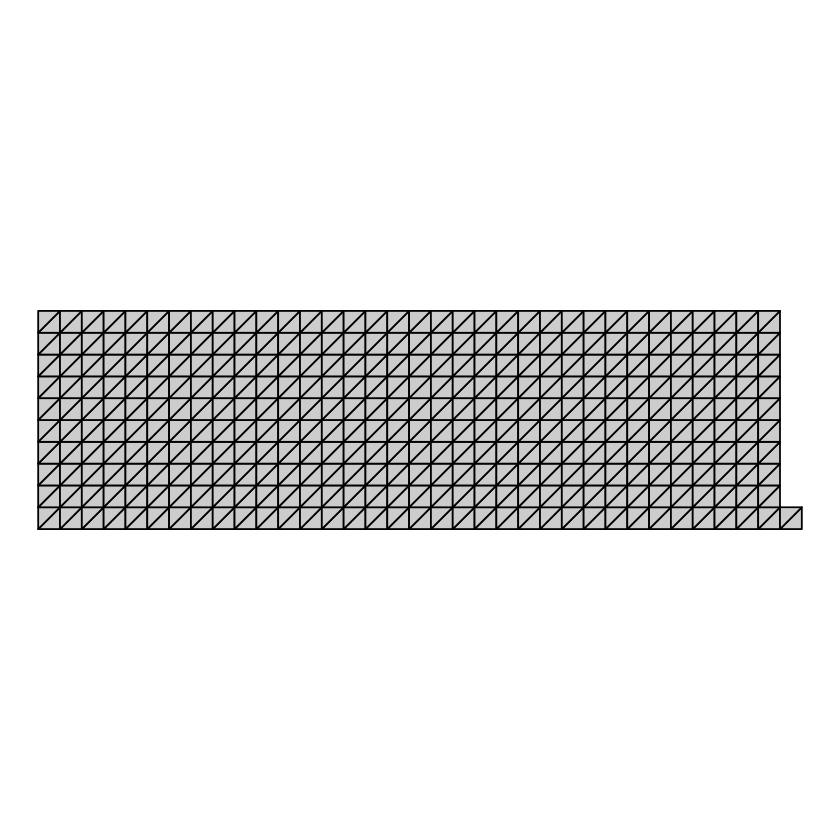

In [18]:
# Load necessary library
library(ggplot2)

# Define fixed height and compute columns
n_rows <- 10  # Fixed height
n_cols <- ceiling(341 / n_rows)  # Compute necessary columns

# Generate coordinates for squares and triangles
data <- data.frame()
count <- 1

for (i in 0:(n_cols-1)) {
  for (j in 0:(n_rows-1)) {
    # Stop when we reach 341 squares
    if (count > 341 * 2) break
    
    # Bottom-left corner of square
    x <- i
    y <- j
    
    # Define two triangles per square
    triangles <- data.frame(
      id = rep(count:(count+1), each=3),
      x = c(x, x+1, x+1,  x, x, x+1),
      y = c(y, y, y+1,  y, y+1, y+1)
    )
    
    # Add to dataset
    data <- rbind(data, triangles)
    count <- count + 2
  }
}

# Trim extra squares if needed
unique_squares <- length(unique(data$id)) / 2
if (unique_squares > 341) {
  excess <- (unique_squares - 341) * 2
  data <- data[!(data$id %in% tail(unique(data$id), excess)), ]
}

# Plot the triangles
ggplot(data, aes(x, y, group = id, fill = factor(id))) +
  geom_polygon(color = "black") +
  scale_fill_manual(values = rep(c("grey80", "grey80"), 341)) +
  theme_void() +
  theme(legend.position = "none") +
  coord_fixed()

Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_segment()`).”


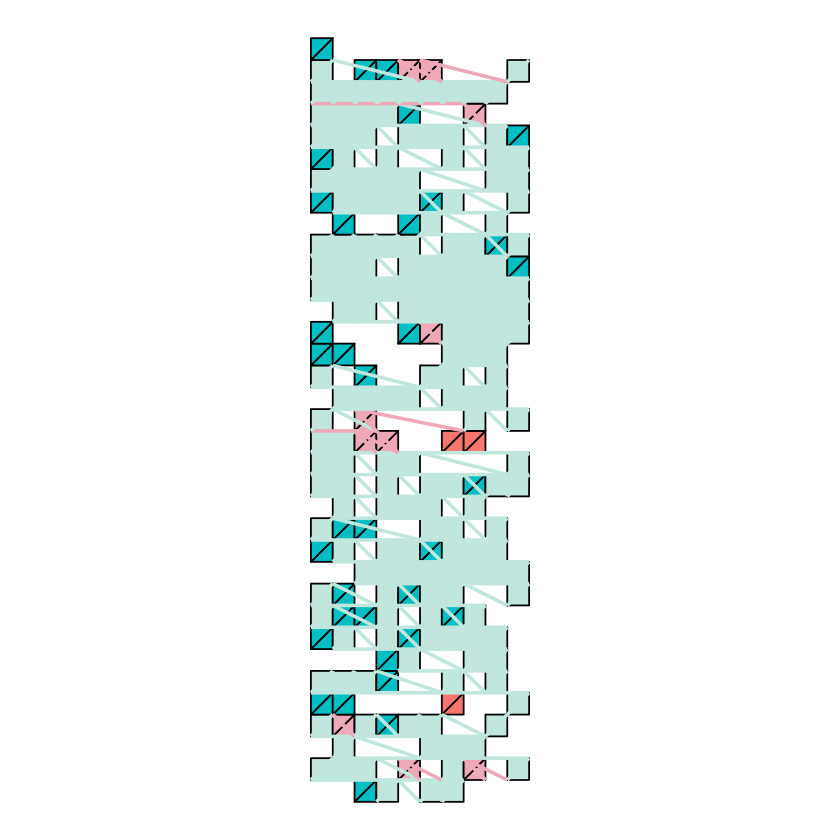

In [20]:
# Load necessary libraries
library(ggplot2)
library(dplyr)
library(tidyr)

# Define grid size (10 x 35)
data <- expand.grid(x = 1:10, y = 1:35) %>%
  head(341) %>%  # Ensure exactly 341 tiles
  mutate(egene = results2$ensembl_id %in% egenes,
         cgene = results2$ensembl_id %in% cgenes,
         crispri_underpowered = results2$ensembl_id %in% crispri.power$gene,
         eqtl_underpowered = results2$ensembl_id %in% eqtl.power$genes)

# Define available groups with priority
group_names <- c("eQTL underpowered", "egene", "CRISPRi underpowered", "cgene")

# Assign categories based on hierarchical priority
data <- data %>%
  rowwise() %>%
  mutate(
    eqtl_underpowered = eqtl_underpowered & !egene,   # Override eQTL underpowered if egene is present
    crispri_underpowered = crispri_underpowered & !cgene,  # Override CRISPRi underpowered if cgene is present
    active_groups = list(group_names[c(eqtl_underpowered, egene, crispri_underpowered, cgene)]),
    category = paste(active_groups, collapse = " & ")  # Combine multiple groups
  ) %>%
  ungroup()

# Replace empty categories with "None"
data$category[data$category == ""] <- "None"

# Define colors for different categories
color_mapping <- c(
  "eQTL underpowered" = "#C0E6DE",
  "CRISPRi underpowered" = "#EEA8B7",
  "cgene" = "#F8766D",
  "egene" = "#00BFC4",
  "None" = "grey80"
)

# Convert `category` into a factor for ordered coloring
data$category <- factor(data$category, levels = names(color_mapping))

# Generate coordinates for squares and triangles
triangle_data <- data.frame()
line_data <- data.frame()
count <- 1

for (i in 1:nrow(data)) {
  x <- data$x[i]
  y <- data$y[i]
  cat <- as.character(data$category[i])

  # Skip if category is missing (NA)
  if (is.na(cat) || cat == "None") next

  # Triangle definitions
  triangles <- data.frame(
    id = rep(count:(count+1), each=3),
    x = c(x, x+1, x+1,  x, x, x+1),
    y = c(y, y, y+1,  y, y+1, y+1),
    category = rep(cat, 6)
  )

  # Add to triangle dataset
  triangle_data <- rbind(triangle_data, triangles)

  # Line definitions for eQTL underpowered & CRISPRi underpowered
  if (cat == "eQTL underpowered") {
    line_data <- rbind(line_data, data.frame(x = c(x, x+1), y = c(y, y+1), category = cat))
  } else if (cat == "CRISPRi underpowered") {
    line_data <- rbind(line_data, data.frame(x = c(x+1, x), y = c(y, y+1), category = cat))
  }

  count <- count + 2
}

# Plot
ggplot() +
  geom_polygon(data = triangle_data, aes(x, y, group = id, fill = category), color = "black") +
  geom_segment(data = line_data, aes(x = x, y = y, xend = lead(x), yend = lead(y), color = category), linewidth = 1) +
  scale_fill_manual(values = color_mapping) +
  scale_color_manual(values = color_mapping) +
  theme_void() +
  theme(legend.position = "none") +
  coord_fixed()


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


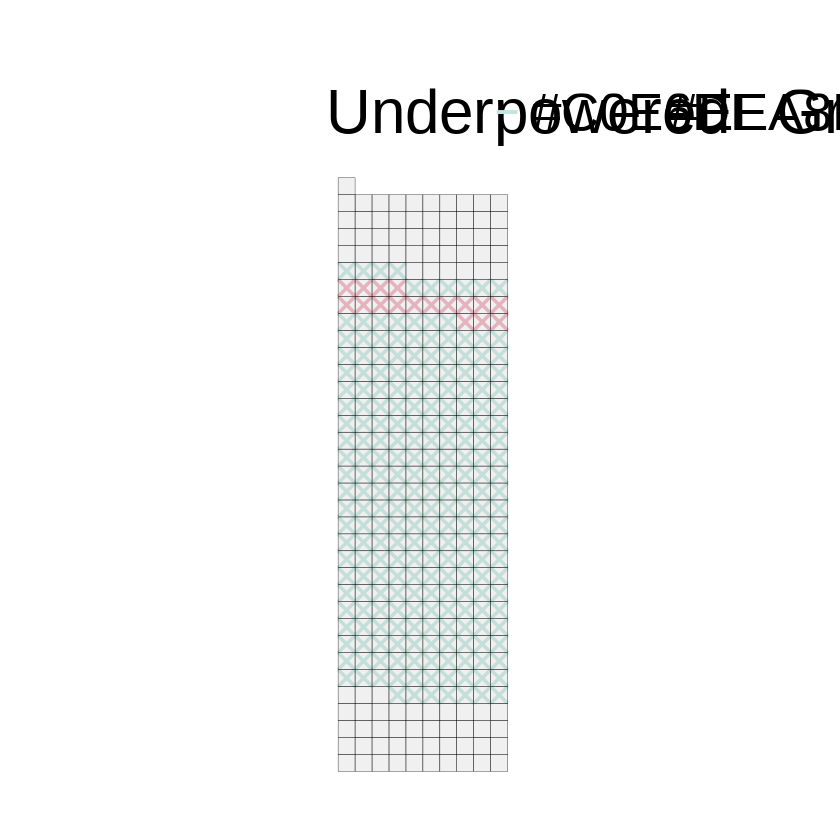

In [16]:
# Load required libraries
library(ggplot2)
library(dplyr)
library(tidyr)
library(tibble)
library(cowplot)

# Create example data
data <- expand.grid(x = 1:10, y = 1:35) %>%
  head(341) %>%  
  mutate(egene = results2$ensembl_id %in% egenes,
         cgene = results2$ensembl_id %in% cgenes,
         crispri_underpowered = results2$ensembl_id %in% crispri.power$gene,
         eqtl_underpowered = results2$ensembl_id %in% eqtl.power$genes)

# Define available groups with priority
group_names <- c("eQTL underpowered", "egene", "CRISPRi underpowered", "cgene")

# Assign categories based on hierarchical priority
data <- data %>%
  rowwise() %>%
  mutate(
    eqtl_underpowered = eqtl_underpowered & !egene,  
    crispri_underpowered = crispri_underpowered & !cgene,  
    active_groups = list(group_names[c(eqtl_underpowered, egene, crispri_underpowered, cgene)]),
    category = ifelse(length(active_groups) == 0, "None", paste(active_groups, collapse = " & "))  
  ) %>%
  ungroup()

# Define colors for each category
category_colors <- c(
  "eQTL underpowered" = "#C0E6DE",
  "CRISPRi underpowered" = "#EEA8B7",
  "cgene" = "#F8766D",
  "egene" = "#00BFC4",
  "None" = "white"
)

# Data sorting process
tmp_data1 = data[data$category == "None",]
tmp_data2 = data[data$category == "eQTL underpowered & CRISPRi underpowered",]
tmp_data3 = data[data$category == "eQTL underpowered",]
tmp_data4 = data[data$category == "CRISPRi underpowered",]
tmp_data5 = data[data$category == "egene & CRISPRi underpowered",]
tmp_data6 = data[data$category == "eQTL underpowered & cgene",]
tmp_data7 = data[data$category == "egene",]
tmp_data8 = data[data$category == "cgene",]
tmp_data9 = data[data$category == "egene & cgene",]

new_xy = expand.grid(x2 = 1:10, y2 = 1:35) %>%
  head(341)

data_sort = cbind(rbind(tmp_data1, tmp_data2, tmp_data3, tmp_data4, tmp_data5, tmp_data6, tmp_data7, tmp_data8, tmp_data9), new_xy)

# Function to create triangle coordinates for diagonal split
make_triangle <- function(x, y, group, color) {
  if (group == "first") {
    # Bottom-left triangle
    tibble(
      x_coord = c(x - 0.5, x + 0.5, x - 0.5),
      y_coord = c(y - 0.5, y + 0.5, y + 0.5),
      fill_color = color
    )
  } else {
    # Top-right triangle
    tibble(
      x_coord = c(x + 0.5, x - 0.5, x + 0.5),
      y_coord = c(y + 0.5, y - 0.5, y - 0.5),
      fill_color = color
    )
  }
}

# Create tile data for split triangles
all_split_tiles <- data_sort %>%
  rowwise() %>%
  mutate(
    first_group = ifelse(length(active_groups) >= 1, active_groups[[1]], "None"),
    second_group = ifelse(length(active_groups) >= 2, active_groups[[2]], "None")  # If single group, second half is blank
  ) %>%
  do(bind_rows(
    make_triangle(.$x2, .$y2, "first", category_colors[.$first_group]),
    make_triangle(.$x2, .$y2, "second", category_colors[.$second_group])
  )) %>%
  ungroup()

# Convert color mapping to factors for the legend
all_split_tiles <- all_split_tiles %>%
  mutate(group_label = factor(fill_color, levels = unique(fill_color)))

# Create lines for underpowered categories
underpowered_lines <- data_sort %>%
  filter(grepl("eQTL underpowered", category) | grepl("CRISPRi underpowered", category)) %>%
  mutate(
    line_color = case_when(
      grepl("eQTL underpowered", category) ~ category_colors["eQTL underpowered"],
      grepl("CRISPRi underpowered", category) ~ category_colors["CRISPRi underpowered"]
    )
  )

# Plot
ggplot() +
  # All diagonal split tiles
  geom_polygon(data = all_split_tiles, aes(x = x_coord, y = y_coord, group = interaction(x_coord, y_coord), fill = fill_color), color = "black") +
  # Add colored diagonal lines for underpowered categories
  geom_segment(data = underpowered_lines, aes(x = x2 - 0.5, y = y2 - 0.5, xend = x2 + 0.5, yend = y2 + 0.5, color = line_color), size = 1) +
  geom_segment(data = underpowered_lines, aes(x = x2 - 0.5, y = y2 + 0.5, xend = x2 + 0.5, yend = y2 - 0.5, color = line_color), size = 1) +
  # Background grid
  geom_tile(data = data_sort, aes(x = x, y = y), fill = "grey80", color = "black", alpha = 0.3) +
  scale_fill_identity(name = "Group", guide = "legend") +
  scale_color_identity(name = "Underpowered", guide = "legend") +  
  coord_fixed() +
  theme_cowplot() +
  theme(
    legend.position = "top",
    axis.line = element_blank(),
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    axis.title = element_blank(),
    plot.background = element_rect(color="white", fill="white"),
    plot.margin = margin(20, 40, 20, 40)
  ) +
  labs(title = "")

In [ ]:
# **Sort the dataset for visual grouping**
data <- data %>%
  mutate(main_group = active_groups[[1]]) %>%  # Extract first (dominant) group
  arrange(num_groups, match(main_group, group_priority))  # Sort by number of groups, then priority

# **Reassign (x, y) positions to cluster colors**
sorted_x <- rep(1:35, each = 10)  # Assign x positions sequentially
sorted_y <- rep(1:10, times = 35) # Assign y positions sequentially

data$x <- sorted_x[1:nrow(data)]
data$y <- sorted_y[1:nrow(data)]

In [29]:
length(results2$ensembl_id)

data <- expand.grid(x = 1:18, y = 1:19) %>%
  head(341) %>%
  mutate(egene = results2$ensembl_id %in% egenes,
        cgene = results2$ensembl_id %in% cgenes,
        crispri_underpowered = results2$ensembl_id %in% crispri.power$gene,
        eqtl_underpowered = results2$ensembl_id %in% eqtl.power$genes)

# Define group categories
data <- data %>%
  mutate(
    category = case_when(
      eqtl_underpowered & crispri_underpowered ~ "eQTL & CRISPRi underpowered",
      egene & cgene ~ "egene & cgene",
      eqtl_underpowered ~ "eQTL underpowered",
      egene ~ "egene",
      crispri_underpowered ~ "CRISPRi underpowered",
      cgene ~ "cgene",
      TRUE ~ "Burden/Mendelian only"
    )
  )

# Define colors for each category
category_colors <- c(
   "Burden/Mendelian only" = "#ECECEC",
      "eQTL underpowered" = "#C0E6DE",
      "CRISPRi underpowered" = "#EEA8B7",
      "cgene" = "#F8766D",
      "egene" = "#00BFC4"
)

head(data)

[1] 341

,x,y,egene,cgene,crispri_underpowered,eqtl_underpowered,category
,<int>,<int>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>
1,1,1,FALSE,FALSE,FALSE,FALSE,Burden/Mendelian only
2,2,1,TRUE,TRUE,FALSE,FALSE,egene & cgene
3,3,1,TRUE,FALSE,FALSE,FALSE,egene
4,4,1,FALSE,FALSE,FALSE,TRUE,eQTL underpowered
5,5,1,FALSE,FALSE,FALSE,FALSE,Burden/Mendelian only
6,6,1,FALSE,FALSE,FALSE,TRUE,eQTL underpowered


In [19]:
# I need a boolean list for each gene saying T/F for that category
data = data.frame(
    
    
    egenes = egenes %in% results2$ensembl_id,
                  cgenes = cgenes %in% results2$results2$ensembl_id,
                  crispri_underpowered = crispri.power$gene %in% results2$results2$ensembl_id,
                  eqtl_underpowered = eqtl.power$genes)
head(data)             

ERROR: Error in data.frame(egenes = egenes %in% results2$ensembl_id, cgenes = cgenes %in% : arguments imply differing number of rows: 742, 154, 66, 234


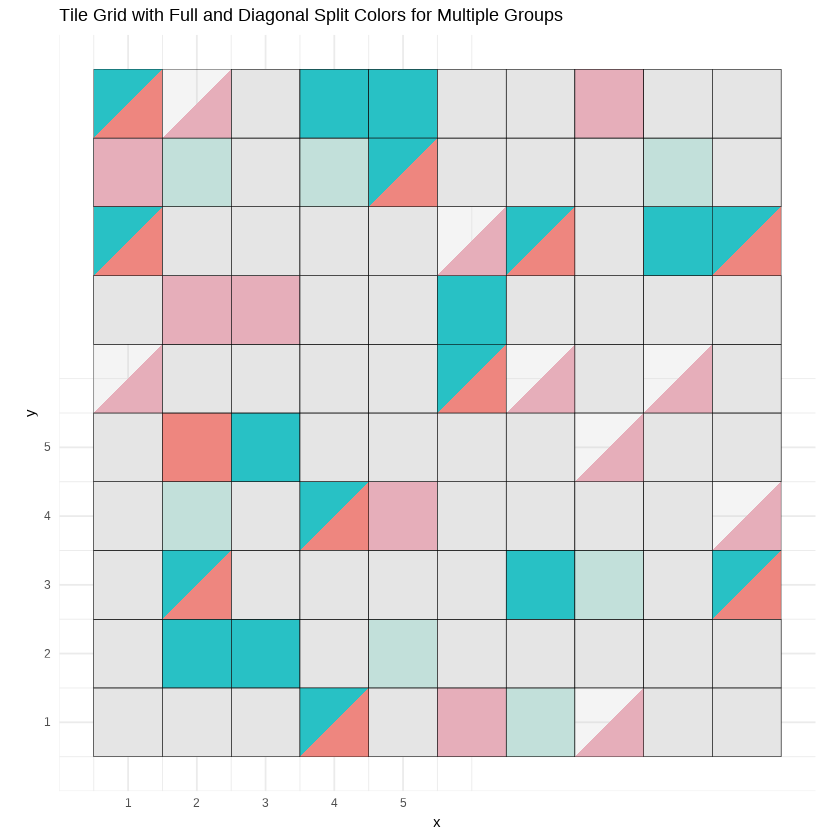

In [17]:
# Create example data
set.seed(123)
data <- expand.grid(x = 1:10, y = 1:10) %>%
  mutate(
    eqtl_underpowered = sample(c(TRUE, FALSE), 100, replace = TRUE),
    egene = sample(c(TRUE, FALSE), 100, replace = TRUE),
    crispri_underpowered = sample(c(TRUE, FALSE), 100, replace = TRUE),
    cgene = sample(c(TRUE, FALSE), 100, replace = TRUE)
  )

# Define group categories
data <- data %>%
  mutate(
    category = case_when(
      burden_mendelian ~ "Burden/Mendelian only",
      eqtl_underpowered & crispri_underpowered ~ "eQTL & CRISPRi underpowered",
      egene & cgene ~ "egene & cgene",
      eqtl_underpowered ~ "eQTL underpowered",
      egene ~ "egene",
      crispri_underpowered ~ "CRISPRi underpowered",
      cgene ~ "cgene",
      TRUE ~ "Burden/Mendelian only"
    )
  )

# Define colors for each category
category_colors <- c(
   "Burden/Mendelian only" = "#ECECEC",
      "eQTL underpowered" = "#C0E6DE",
      "CRISPRi underpowered" = "#EEA8B7",
      "cgene" = "#F8766D",
      "egene" = "#00BFC4"
)

# Define which groups need diagonal splitting (two categories in one square)
diagonal_splits <- c("eQTL & CRISPRi underpowered", "egene & cgene")

# Function to create triangle coordinates for diagonal split
make_triangle <- function(x, y, group) {
  if (group == "first") {
    # Bottom-left triangle
    tibble(
      x_coord = c(x - 0.5, x + 0.5, x - 0.5),
      y_coord = c(y - 0.5, y + 0.5, y + 0.5)
    )
  } else {
    # Top-right triangle
    tibble(
      x_coord = c(x + 0.5, x - 0.5, x + 0.5),
      y_coord = c(y + 0.5, y - 0.5, y - 0.5)
    )
  }
}

# Separate full tiles and diagonal splits
full_tiles <- data %>%
  filter(!(category %in% diagonal_splits)) %>%
  mutate(fill_color = category_colors[category])

split_tiles <- data %>%
  filter(category %in% diagonal_splits) %>%
  rowwise() %>%
  mutate(
    first_group = strsplit(category, " & ")[[1]][1],  # Extract first group
    second_group = strsplit(category, " & ")[[1]][2]  # Extract second group
  ) %>%
  pivot_longer(cols = c(first_group, second_group), names_to = "part", values_to = "group") %>%
  mutate(fill_color = category_colors[group]) %>%
  rowwise() %>%
  mutate(coords = list(make_triangle(x, y, ifelse(part == "first_group", "first", "second")))) %>%
  unnest(coords)

# Plot
ggplot() +
  # Full color tiles for single-group squares
  geom_tile(data = full_tiles, aes(x = x, y = y, fill = fill_color), color = "black") +
  # Diagonal split tiles
  geom_polygon(data = split_tiles, aes(x = x_coord, y = y_coord, group = interaction(x, y, group), fill = fill_color), color = NA) +
  # Background grid
  geom_tile(data = data, aes(x = x, y = y), fill = "grey80", color = "black", alpha = 0.2) +
  scale_x_continuous(breaks = 1:5) +
  scale_y_continuous(breaks = 1:5) +
  scale_fill_identity() +  # Use predefined colors
  coord_fixed() +
  theme_minimal() +
  labs(title = "Tile Grid with Full and Diagonal Split Colors for Multiple Groups")
